#Import Libraries

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm
import numpy as np
from datetime import datetime, timedelta
from statsmodels.stats.power import NormalIndPower

# Generate mock A/B test data

In [2]:
np.random.seed(42)
num_users_per_group = 5000
start_date = datetime(2023, 11, 1)
test_duration_days = 14 # 2 week test

Control Group (A)

In [3]:
control_user_ids = [f'UserA_{10000+i}' for i in range(num_users_per_group)]
control_group_assignment = ['Control'] * num_users_per_group

Assume a baseline conversion rate of 10% for control

In [4]:
control_conversions = np.random.binomial(1, 0.10, num_users_per_group)
control_clicks = np.random.randint(0, 15, num_users_per_group) # Clicks per user
control_page_views = control_clicks + np.random.randint(1, 5, num_users_per_group) # Page views > clicks
control_page_views = np.maximum(1, control_page_views) # At least 1 page view

Treatment Group (B) - let's assume a slight lift

In [5]:
treatment_user_ids = [f'UserB_{20000+i}' for i in range(num_users_per_group)]
treatment_group_assignment = ['Treatment'] * num_users_per_group

Assume a target conversion rate of 11.5% for treatment (1.5% lift)

In [6]:
treatment_conversions = np.random.binomial(1, 0.115, num_users_per_group)
treatment_clicks = np.random.randint(0, 17, num_users_per_group) # Slightly more clicks
treatment_page_views = treatment_clicks + np.random.randint(1, 5, num_users_per_group)
treatment_page_views = np.maximum(1, treatment_page_views)

 Combine data

In [7]:
all_user_ids = control_user_ids + treatment_user_ids
all_groups = control_group_assignment + treatment_group_assignment
all_conversions = np.concatenate([control_conversions, treatment_conversions])
all_clicks = np.concatenate([control_clicks, treatment_clicks])
all_page_views = np.concatenate([control_page_views, treatment_page_views])

Assign random dates within the test period

In [8]:
all_dates = [ (start_date + timedelta(days=np.random.randint(0, test_duration_days))).strftime('%Y-%m-%d')
              for _ in range(num_users_per_group * 2) ]
df_ab_test = pd.DataFrame({
    'UserID': all_user_ids,
    'Group': all_groups,
    'Date': all_dates,
    'PageViews': all_page_views,
    'Clicks': all_clicks,
    'Converted': all_conversions
})

Ensure clicks are not more than page views (though unlikely with current generation)

In [9]:
df_ab_test['Clicks'] = df_ab_test.apply(lambda row: min(row['Clicks'], row['PageViews']), axis=1)

Save to CSV

In [10]:
df_ab_test.to_csv('ab_test_results_mock_data.csv', index=False)
df_ab_test.sample(10, random_state=42)

,UserID,Group,Date,PageViews,Clicks,Converted
6252,UserB_21252,Treatment,2023-11-07,8,4,0
4684,UserA_14684,Control,2023-11-10,5,1,0
1731,UserA_11731,Control,2023-11-04,8,6,0
4742,UserA_14742,Control,2023-11-12,3,2,0
4521,UserA_14521,Control,2023-11-12,12,8,0
6340,UserB_21340,Treatment,2023-11-03,7,3,0
576,UserA_10576,Control,2023-11-08,4,0,0
5202,UserB_20202,Treatment,2023-11-05,15,14,1
6363,UserB_21363,Treatment,2023-11-12,16,14,1
439,UserA_10439,Control,2023-11-08,9,8,0


Basic check of conversion rates

In [11]:
print("\nOverall Conversion Rates by Group:")
df_ab_test.groupby('Group')['Converted'].mean()


Overall Conversion Rates by Group:


,Converted
Group,
Control,0.0958
Treatment,0.1180


#Data cleaning

Check for missing data

In [12]:
df_ab_test.isnull().sum()

,0
UserID,0
Group,0
Date,0
PageViews,0
Clicks,0
Converted,0


 Check for duplicate UserIDs in both groups

In [13]:
user_group_counts = df_ab_test.groupby('UserID')['Group'].nunique()
user_group_counts[user_group_counts > 1]

,Group
UserID,


Summary statistics to detect outliers

In [14]:
df_ab_test[['PageViews', 'Clicks', 'Converted']].describe()

,PageViews,Clicks,Converted
count,10000.000000,10000.000000,10000.000000
mean,10.004400,7.500500,0.106900
std,4.793963,4.665295,0.309002
min,1.000000,0.000000,0.000000
25%,6.000000,3.000000,0.000000
50%,10.000000,7.500000,0.000000
75%,14.000000,11.000000,0.000000
max,20.000000,16.000000,1.000000


 Check for users with PageViews < Clicks (illogical)

In [15]:
illogical_rows = df_ab_test[df_ab_test['Clicks'] > df_ab_test['PageViews']]

Number of unique users vs total rows

In [16]:
unique_users = df_ab_test['UserID'].nunique()
total_rows = len(df_ab_test)
display(name="Illogical Rows", dataframe=illogical_rows)

#Calculate Key Metrics:

Group by 'Group' and calculate conversion metrics

In [17]:
df_ab_test_clean = df_ab_test[df_ab_test['Clicks'] <= df_ab_test['PageViews']]
conversion_metrics = df_ab_test_clean.groupby('Group').agg(
    Total_Users=('UserID', 'count'),
    Total_Conversions=('Converted', 'sum')
)

Calculate conversion rate

In [18]:
conversion_metrics['Conversion_Rate'] = (
    conversion_metrics['Total_Conversions'] / conversion_metrics['Total_Users']
)
conversion_metrics

,Total_Users,Total_Conversions,Conversion_Rate
Group,,,
Control,5000,479,0.0958
Treatment,5000,590,0.1180


Calculate observed difference in conversion rates

In [19]:
observed_difference = (
    conversion_metrics.loc['Treatment', 'Conversion_Rate'] -
    conversion_metrics.loc['Control', 'Conversion_Rate']
)
print(observed_difference)

0.022199999999999998


#Statistical Significance Testing Results

**Hypotheses**

Null Hypothesis (H₀): The conversion rates are the same for control and treatment groups.

Alternative Hypothesis (H₁): The conversion rates are different between the groups.



Extract data for Z-test

In [20]:
conversions = conversion_metrics['Total_Conversions'].values
totals = conversion_metrics['Total_Users'].values

Perform Z-test for proportions

In [21]:
z_stat, p_value = proportions_ztest(count=conversions, nobs=totals)
print(z_stat)

-3.59239498548479


In [22]:
print(p_value)

0.000327652709954209


Calculate confidence interval for the difference in proportions

In [23]:
diff = conversion_metrics.loc['Treatment', 'Conversion_Rate'] - conversion_metrics.loc['Control', 'Conversion_Rate']
se = np.sqrt(
    (conversion_metrics.loc['Control', 'Conversion_Rate'] * (1 - conversion_metrics.loc['Control', 'Conversion_Rate']) / totals[0]) +
    (conversion_metrics.loc['Treatment', 'Conversion_Rate'] * (1 - conversion_metrics.loc['Treatment', 'Conversion_Rate']) / totals[1])
)
margin_of_error = 1.96 * se
ci_diff = (diff - margin_of_error, diff + margin_of_error)
print(ci_diff)

(np.float64(0.010095564285965246), np.float64(0.03430443571403475))


#Practical Significance and Power Analysis

Calculate practical uplift

In [24]:
conversion_control = conversion_metrics.loc['Control', 'Conversion_Rate']
conversion_treatment = conversion_metrics.loc['Treatment', 'Conversion_Rate']
uplift = (conversion_treatment - conversion_control) / conversion_control * 100  # in percent
print(uplift)

23.173277661795407


Power analysis: only relevant if the result was NOT significant, but we include this for completeness using statsmodels

In [25]:
effect_size = sm.stats.proportion_effectsize(conversion_treatment, conversion_control)
analysis = NormalIndPower()
power = analysis.power(effect_size=effect_size, nobs1=totals[0], alpha=0.05, ratio=1.0, alternative='two-sided')

print("effect_size is ",effect_size)

effect_size is  0.07193882250897876


In [26]:
print("Power is",power)

Power is 0.949182390735705


# Important Plots

1. Distribution of user behavior (PageViews, Clicks, Converted).

2. Bar chart of conversion rates by group (Control vs Treatment).

3. Confidence interval visualization (conversion uplift with error bars).

4. Observed vs Expected counts (Chi-Square test visualization).

5. Power analysis curve (Effect size vs Statistical Power).

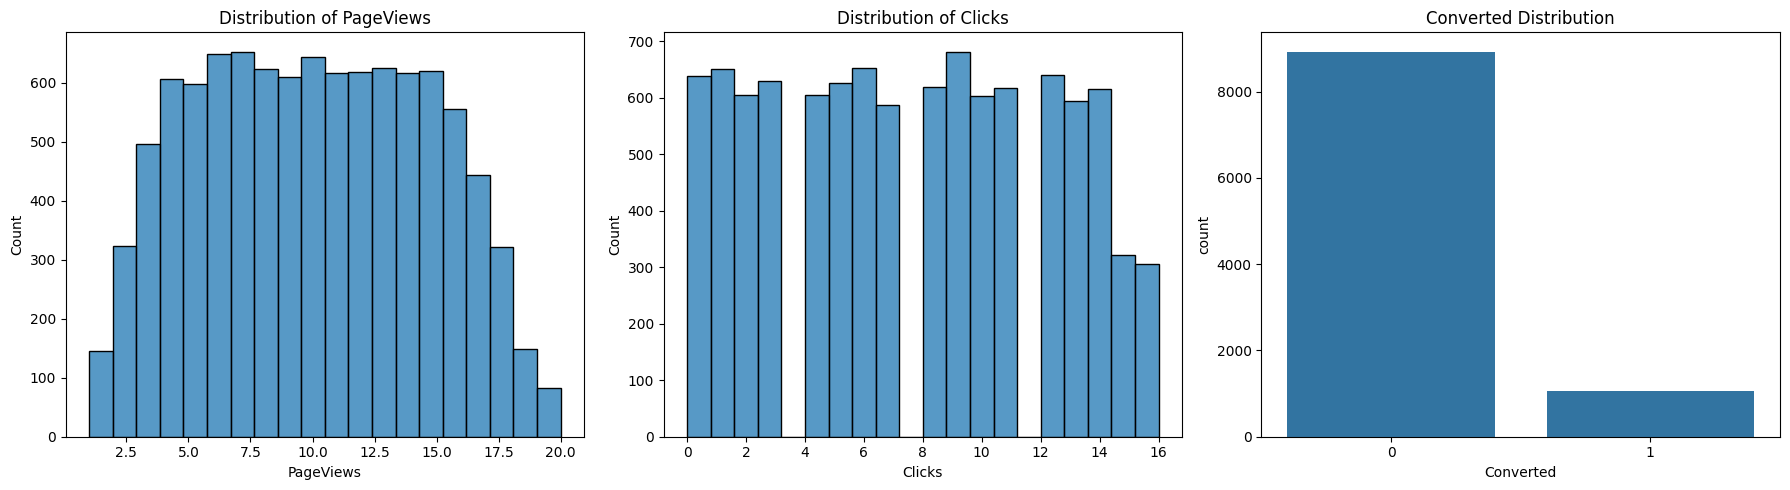

In [29]:
# 1. Distribution of PageViews, Clicks, and Conversion
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df_ab_test['PageViews'], bins=20, kde=False, ax=axes[0])
axes[0].set_title("Distribution of PageViews")
sns.histplot(df_ab_test['Clicks'], bins=20, kde=False, ax=axes[1])
axes[1].set_title("Distribution of Clicks")
sns.countplot(x='Converted', data=df_ab_test, ax=axes[2])
axes[2].set_title("Converted Distribution")
plt.tight_layout()
plt.savefig("distributions.png")
plt.show()

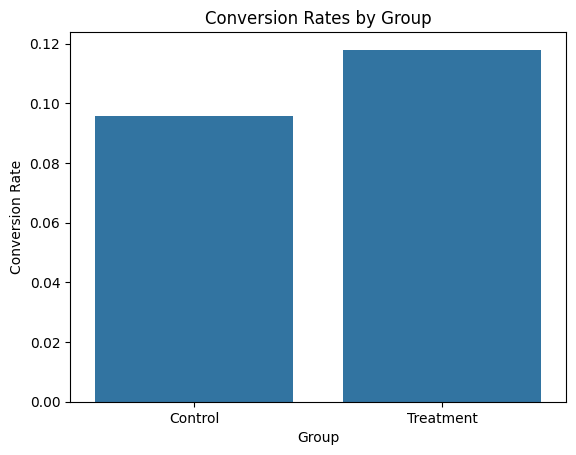

In [31]:
# 2. Conversion Rate by Group (bar chart)
conversion_rates = df_ab_test.groupby("Group")['Converted'].mean().reset_index()
sns.barplot(x="Group", y="Converted", data=conversion_rates)
plt.title("Conversion Rates by Group")
plt.ylabel("Conversion Rate")
plt.savefig("conversion_rates.png")
plt.show()

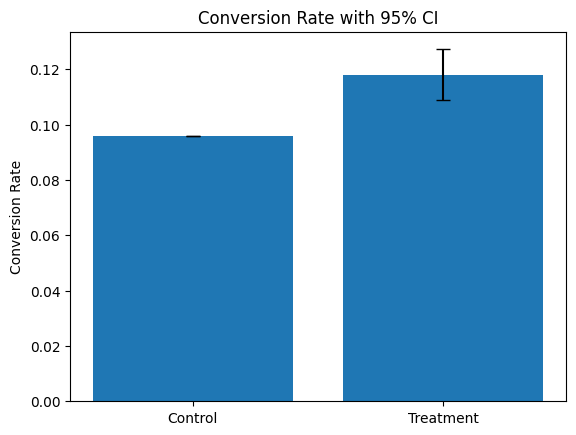

In [32]:
# 3. Confidence Interval for Conversion Rates
import statsmodels.api as sm
control_rate = 479/5000
treatment_rate = 590/5000
ci_low, ci_high = sm.stats.proportion_confint(count=[479,590], nobs=[5000,5000], alpha=0.05, method='wilson')[1]
plt.bar(["Control","Treatment"], [control_rate, treatment_rate], yerr=[0, (ci_high-treatment_rate)], capsize=5)
plt.title("Conversion Rate with 95% CI")
plt.ylabel("Conversion Rate")
plt.savefig("confidence_interval.png")
plt.show()

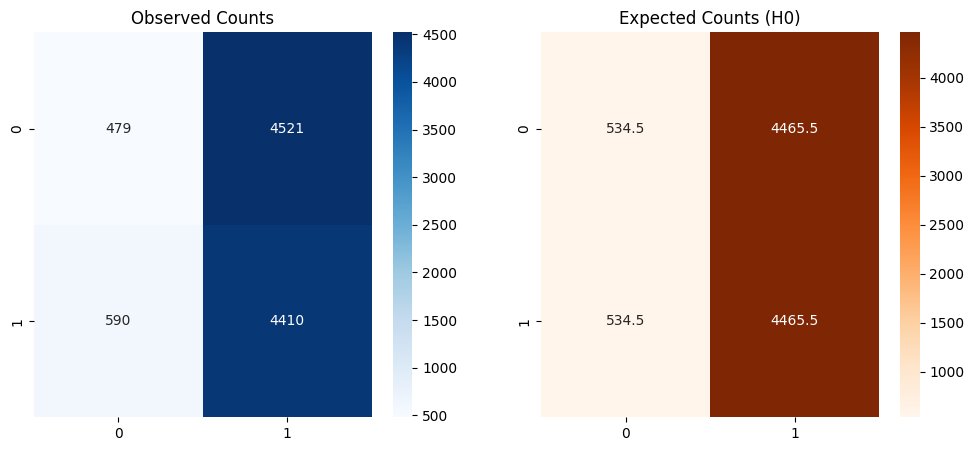

In [33]:
# 4. Observed vs Expected (Chi-Square Test)
observed = np.array([[479, 4521],[590, 4410]])
expected = np.array([[534.5, 4465.5],[534.5,4465.5]])
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(observed, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title("Observed Counts")
sns.heatmap(expected, annot=True, fmt=".1f", cmap="Oranges", ax=ax[1])
ax[1].set_title("Expected Counts (H0)")
plt.savefig("chi_square.png")
plt.show()

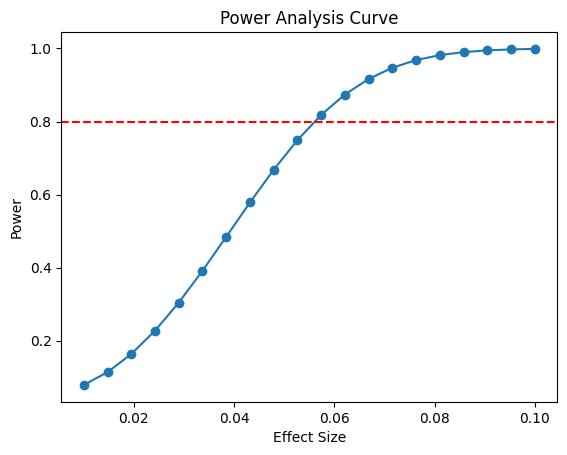

In [34]:

# 5. Power Analysis Curve
import statsmodels.stats.power as smp
effect_sizes = np.linspace(0.01, 0.1, 20)
powers = [smp.NormalIndPower().power(effect_size=e, nobs1=5000, alpha=0.05, ratio=1) for e in effect_sizes]
plt.plot(effect_sizes, powers, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.title("Power Analysis Curve")
plt.xlabel("Effect Size")
plt.ylabel("Power")
plt.savefig("power_curve.png")
plt.show()
